# Lab 3: Script-kiddie Machine Learning Model Fitting and Evaluation

### Objectives

* Task uses one dataset, credit card fraud. load using fetch_openml
* Use sklearn pipeline from that one example for test-train-split, preprocessing and fitting
* Fit 3 different classifiers models (e.g., logistic regression, SVM, decision tree) with their defaults
* Plot the three models on a ROC curve and on a precision-recall curve
* For each model, report:
    * accuracy ( is accuracy just the "model score" in this case? )
    * AUC of ROC
    * AUC of precision-recall
* For the model with the highest precision-recall AUC, report the cutoff threshold that maximizes the F1 score. Report the confusion matrix for the same threshold.

In [39]:
# Setup/Imports
import numpy as np
import pandas as pd

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import average_precision_score

print('Setup complete')

Setup complete


In [10]:
# Load credit card fraud dataset using fetch_openml
# Note: scikit-learn NEEDS TO BE UPDATED to use as_frame parameter
# > conda list scikit-learn
# > pip install -U scikit-learn

X, y = fetch_openml(data_id='42175', return_X_y=True, as_frame=True) 

print('n records: {}'.format(len(X.index)))

n records: 284807


### Define Preprocessing Steps and build a Pipeline

In [27]:
# Define Preprocessing Steps

scaler = StandardScaler()

unscaled_features = ['Time', 'Amount']

scale_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('scale', scale_transformer, unscaled_features)
    ])


In [34]:
# Append classifiers to preprocessing pipeline

classifiers = [
    LogisticRegression(),
    DecisionTreeClassifier(),
    RandomForestClassifier()
]

clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('clf', None)])

In [35]:
# Split data into training and validation

train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 0)

### Fit the Models

In [51]:
# Using the training data, fit the three models and print the results of the tests

roc_things = []
precision_recall_things = []

for classifier in classifiers:
    clf.set_params(clf=classifier).fit(train_X, train_y)
    classifier_name = classifier.__class__.__name__
    print(str(classifier))
    print("Model Score (Accuracy): %.3f" % clf.score(val_X, val_y))
    
    
    y_score = clf.predict_proba(val_X)[:,1]
    
    roc_auc = roc_auc_score(val_y, y_score)
    fpr, tpr, _ = roc_curve(val_y, y_score)
    roc_things.append((fpr, tpr, '{} AUC: {:.3f}'.format(classifier_name, roc_auc)))
    
    precision, recall, thresholds = precision_recall_curve(val_y, y_score)
    pr_auc = auc(recall, precision)
    precision_recall_things.append((recall, precision, thresholds, '{} AUC: {:.3f}'.format(classifier_name, pr_auc)))
    #plot_precision_recall_curve(clf, X_test, y_test)
    
    print('Average Precision Score: {:.3f}'.format(average_precision_score(val_y, y_score)))
    print('ROC AUC Score: {:.3f}'.format(roc_auc))
    print('Precision-Recall AUC: {:.3f}'.format(pr_auc))
    print()

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Model Score (Accuracy): 0.998
Average Precision Score: 0.002
ROC AUC Score: 0.576
Precision-Recall AUC: 0.002

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
Model Score (Accuracy): 0.997
Average Precision Score: 0.017
ROC AUC Score: 0.562
Precision-Recall AUC: 0.124

RandomForestClassifier(bo

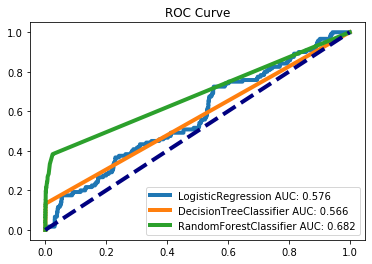

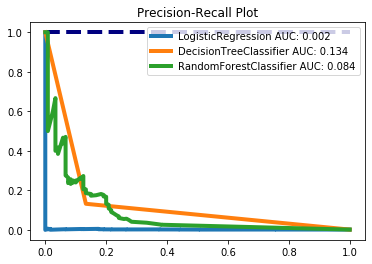

In [49]:
# Plot the ROC curve and Precision-Recall Plot

import matplotlib.pyplot as plt

# ROC curve
roc_plt = plt.figure()
lw = 4

for roc_thing in roc_things:
    fpr, tpr, label = roc_thing
    plt.plot(fpr, tpr, lw=lw, label=label)
    
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--') # dadgum no-skill line
plt.legend()
plt.title('ROC Curve')
  
# Precision Recall Plot    
pr_plt = plt.figure()

for pr_thing in precision_recall_things:
    recall, precision, _, label = pr_thing
    plt.plot(recall, precision, lw=lw, label=label)
ratio = val_y[val_y].shape[0] / val_y.shape[0]

plt.hlines(y=ratio, xmin=0, xmax=1, color='navy', lw=lw, linestyle='--') # dadgum no-skill line
plt.title('Precision-Recall Plot')
plt.legend()

In [52]:
# best was random forest...
from scipy.stats import hmean
import numpy.ma as ma

recall, precision, thresholds, _ = precision_recall_things[1] # random forest

# make a 2D numpy array out of our recall and precision values
a = np.column_stack((recall, precision))

# harmonic mean is only valid for values greater than 0.
# "mask" out any rows with values less than or equal to 0
# https://docs.scipy.org/doc/numpy/reference/maskedarray.generic.html
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.ma.mask_rows.html
a = ma.masked_less_equal(a, 0)
a = ma.mask_rows(a)
f1 = hmean(a,axis=1)

# np.argmax returns the index of the largest value in an array. This will map to the threshold array that
# was associated with the precision and recall which generated that "best F1 score"
# I'm sure there's a better way to do the above, but IDK I'm a noob
threshold_that_maximizes_f1 = thresholds[np.argmax(f1)]
print('Threshold that Optimizes F1: {}'.format(threshold_that_maximizes_f1))

Threshold that Optimizes F1: 1.0
